## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import tensorflow.keras as keras
import itertools
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)  
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)) 

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128],situation = 0):
    if situation == 0:
        input_layer = keras.layers.Input(input_shape)

        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(input_layer)
                x = BatchNormalization()(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(x)
                x = BatchNormalization()(x)
    elif situation == 1:
        input_layer = keras.layers.Input(input_shape)

        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = BatchNormalization()(input_layer)
                
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(x)
            else:
                x = BatchNormalization()(x)
                
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(x)
    elif situation == 2:
        input_layer = keras.layers.Input(input_shape)
        x = BatchNormalization()(input_layer)

        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1))(x)

    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [32, 128, 256]
MOMENTUM = 0.95
SITUATION = [0, 1, 2]
SIT = ["BN在Activation之後", "BN在Activation之前", "BN在Input layer之後"]

In [7]:
results = {}
"""
以迴圈方式遍歷組合來訓練模型
"""
for bs, s in itertools.product(BATCH_SIZE, SITUATION):
    print("Batch_size = %.0f, Situation為 %s" % (bs, SIT[s]))
    model = build_mlp(input_shape=x_train.shape[1:], situation=s)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bs, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)

    # Collect results
    exp_name_tag = ("Batch_size = %f, Situation為 %s" % (bs, SIT[s]))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Batch_size = 32, Situation為 BN在Activation之後
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizati

1563/1563 [==============================] - 5s 3ms/step - loss: 0.8487 - accuracy: 0.6959 - val_loss: 1.6206 - val_accuracy: 0.5009
Epoch 48/50
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8336 - accuracy: 0.7023 - val_loss: 1.5446 - val_accuracy: 0.5145
Epoch 49/50
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8233 - accuracy: 0.7047 - val_loss: 1.5584 - val_accuracy: 0.5202
Epoch 50/50
1563/1563 [==============================] - 5s 3ms/step - loss: 0.8146 - accuracy: 0.7084 - val_loss: 1.5600 - val_accuracy: 0.5106
Batch_size = 32, Situation為 BN在Activation之前
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 3072)              12288     
_________________________________________

1563/1563 [==============================] - 5s 3ms/step - loss: 0.3102 - accuracy: 0.8896 - val_loss: 2.0574 - val_accuracy: 0.5345
Epoch 44/50
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2983 - accuracy: 0.8939 - val_loss: 2.0539 - val_accuracy: 0.5448
Epoch 45/50
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2910 - accuracy: 0.8964 - val_loss: 2.0853 - val_accuracy: 0.5417
Epoch 46/50
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2900 - accuracy: 0.8964 - val_loss: 2.1281 - val_accuracy: 0.5352
Epoch 47/50
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2837 - accuracy: 0.9004 - val_loss: 2.1110 - val_accuracy: 0.5442
Epoch 48/50
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2682 - accuracy: 0.9056 - val_loss: 2.1477 - val_accuracy: 0.5396
Epoch 49/50
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2657 - accuracy: 0.9054 - val_loss: 2.1621 - val_accuracy: 0.53

1563/1563 [==============================] - 3s 2ms/step - loss: 0.2520 - accuracy: 0.9115 - val_loss: 2.5189 - val_accuracy: 0.5368
Epoch 42/50
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2350 - accuracy: 0.9187 - val_loss: 2.6038 - val_accuracy: 0.5307
Epoch 43/50
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2278 - accuracy: 0.9204 - val_loss: 2.5898 - val_accuracy: 0.5344
Epoch 44/50
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2224 - accuracy: 0.9215 - val_loss: 2.6626 - val_accuracy: 0.5354
Epoch 45/50
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2197 - accuracy: 0.9225 - val_loss: 2.6205 - val_accuracy: 0.5273
Epoch 46/50
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2200 - accuracy: 0.9253 - val_loss: 2.6558 - val_accuracy: 0.5331
Epoch 47/50
1563/1563 [==============================] - 3s 2ms/step - loss: 0.2030 - accuracy: 0.9289 - val_loss: 2.6982 - val_accuracy: 0.53

391/391 [==============================] - 1s 4ms/step - loss: 0.3888 - accuracy: 0.8645 - val_loss: 2.3697 - val_accuracy: 0.4629
Epoch 39/50
391/391 [==============================] - 2s 4ms/step - loss: 0.3676 - accuracy: 0.8748 - val_loss: 2.3819 - val_accuracy: 0.4522
Epoch 40/50
391/391 [==============================] - 2s 4ms/step - loss: 0.3602 - accuracy: 0.8767 - val_loss: 2.2015 - val_accuracy: 0.4705
Epoch 41/50
391/391 [==============================] - 1s 4ms/step - loss: 0.3331 - accuracy: 0.8866 - val_loss: 2.3634 - val_accuracy: 0.4517
Epoch 42/50
391/391 [==============================] - 1s 4ms/step - loss: 0.3331 - accuracy: 0.8864 - val_loss: 2.4114 - val_accuracy: 0.4597
Epoch 43/50
391/391 [==============================] - 2s 4ms/step - loss: 0.3213 - accuracy: 0.8910 - val_loss: 2.4233 - val_accuracy: 0.4706
Epoch 44/50
391/391 [==============================] - 1s 4ms/step - loss: 0.3040 - accuracy: 0.8974 - val_loss: 2.6783 - val_accuracy: 0.4481
Epoch 45/50

391/391 [==============================] - 1s 4ms/step - loss: 0.1214 - accuracy: 0.9634 - val_loss: 2.3465 - val_accuracy: 0.5254
Epoch 36/50
391/391 [==============================] - 1s 3ms/step - loss: 0.1191 - accuracy: 0.9638 - val_loss: 2.3658 - val_accuracy: 0.5148
Epoch 37/50
391/391 [==============================] - 1s 4ms/step - loss: 0.1087 - accuracy: 0.9693 - val_loss: 2.3736 - val_accuracy: 0.5244
Epoch 38/50
391/391 [==============================] - 1s 4ms/step - loss: 0.1026 - accuracy: 0.9696 - val_loss: 2.3889 - val_accuracy: 0.5221
Epoch 39/50
391/391 [==============================] - 1s 3ms/step - loss: 0.0972 - accuracy: 0.9716 - val_loss: 2.4265 - val_accuracy: 0.5201
Epoch 40/50
391/391 [==============================] - 1s 3ms/step - loss: 0.0905 - accuracy: 0.9739 - val_loss: 2.4569 - val_accuracy: 0.5163
Epoch 41/50
391/391 [==============================] - 1s 4ms/step - loss: 0.0861 - accuracy: 0.9750 - val_loss: 2.4673 - val_accuracy: 0.5237
Epoch 42/50

391/391 [==============================] - 1s 3ms/step - loss: 0.1509 - accuracy: 0.9527 - val_loss: 2.5650 - val_accuracy: 0.5118
Epoch 35/50
391/391 [==============================] - 1s 3ms/step - loss: 0.1390 - accuracy: 0.9567 - val_loss: 2.5951 - val_accuracy: 0.5157
Epoch 36/50
391/391 [==============================] - 1s 3ms/step - loss: 0.1298 - accuracy: 0.9594 - val_loss: 2.7034 - val_accuracy: 0.5141
Epoch 37/50
391/391 [==============================] - 1s 3ms/step - loss: 0.1201 - accuracy: 0.9625 - val_loss: 2.7194 - val_accuracy: 0.5150
Epoch 38/50
391/391 [==============================] - 1s 3ms/step - loss: 0.1103 - accuracy: 0.9659 - val_loss: 2.7188 - val_accuracy: 0.5202
Epoch 39/50
391/391 [==============================] - 1s 3ms/step - loss: 0.1103 - accuracy: 0.9649 - val_loss: 2.8079 - val_accuracy: 0.5142
Epoch 40/50
391/391 [==============================] - 1s 3ms/step - loss: 0.1128 - accuracy: 0.9648 - val_loss: 2.8722 - val_accuracy: 0.5176
Epoch 41/50

196/196 [==============================] - 1s 5ms/step - loss: 0.4583 - accuracy: 0.8522 - val_loss: 1.9805 - val_accuracy: 0.4558
Epoch 32/50
196/196 [==============================] - 1s 4ms/step - loss: 0.4361 - accuracy: 0.8598 - val_loss: 2.0626 - val_accuracy: 0.4626
Epoch 33/50
196/196 [==============================] - 1s 5ms/step - loss: 0.4181 - accuracy: 0.8668 - val_loss: 2.1093 - val_accuracy: 0.4520
Epoch 34/50
196/196 [==============================] - 1s 4ms/step - loss: 0.3960 - accuracy: 0.8744 - val_loss: 2.0818 - val_accuracy: 0.4604
Epoch 35/50
196/196 [==============================] - 1s 4ms/step - loss: 0.3741 - accuracy: 0.8814 - val_loss: 2.0347 - val_accuracy: 0.4698
Epoch 36/50
196/196 [==============================] - 1s 5ms/step - loss: 0.3570 - accuracy: 0.8887 - val_loss: 2.0525 - val_accuracy: 0.4752
Epoch 37/50
196/196 [==============================] - 1s 4ms/step - loss: 0.3360 - accuracy: 0.8962 - val_loss: 2.0815 - val_accuracy: 0.4667
Epoch 38/50

196/196 [==============================] - 1s 5ms/step - loss: 0.2152 - accuracy: 0.9466 - val_loss: 1.9115 - val_accuracy: 0.5109
Epoch 29/50
196/196 [==============================] - 1s 4ms/step - loss: 0.2018 - accuracy: 0.9504 - val_loss: 1.9399 - val_accuracy: 0.5165
Epoch 30/50
196/196 [==============================] - 1s 4ms/step - loss: 0.1835 - accuracy: 0.9568 - val_loss: 2.0079 - val_accuracy: 0.5081
Epoch 31/50
196/196 [==============================] - 1s 5ms/step - loss: 0.1645 - accuracy: 0.9630 - val_loss: 2.0028 - val_accuracy: 0.5143
Epoch 32/50
196/196 [==============================] - 1s 4ms/step - loss: 0.1474 - accuracy: 0.9672 - val_loss: 2.0698 - val_accuracy: 0.5121
Epoch 33/50
196/196 [==============================] - 1s 5ms/step - loss: 0.1358 - accuracy: 0.9709 - val_loss: 2.1098 - val_accuracy: 0.5130
Epoch 34/50
196/196 [==============================] - 1s 4ms/step - loss: 0.1325 - accuracy: 0.9704 - val_loss: 2.1369 - val_accuracy: 0.5117
Epoch 35/50

196/196 [==============================] - 1s 4ms/step - loss: 0.4212 - accuracy: 0.8712 - val_loss: 1.7077 - val_accuracy: 0.5295
Epoch 28/50
196/196 [==============================] - 1s 4ms/step - loss: 0.3897 - accuracy: 0.8831 - val_loss: 1.7440 - val_accuracy: 0.5232
Epoch 29/50
196/196 [==============================] - 1s 4ms/step - loss: 0.3609 - accuracy: 0.8933 - val_loss: 1.8251 - val_accuracy: 0.5207
Epoch 30/50
196/196 [==============================] - 1s 4ms/step - loss: 0.3357 - accuracy: 0.9014 - val_loss: 1.8367 - val_accuracy: 0.5191
Epoch 31/50
196/196 [==============================] - 1s 4ms/step - loss: 0.3123 - accuracy: 0.9097 - val_loss: 1.8828 - val_accuracy: 0.5156
Epoch 32/50
196/196 [==============================] - 1s 4ms/step - loss: 0.2866 - accuracy: 0.9182 - val_loss: 1.9424 - val_accuracy: 0.5207
Epoch 33/50
196/196 [==============================] - 1s 4ms/step - loss: 0.2646 - accuracy: 0.9254 - val_loss: 1.9667 - val_accuracy: 0.5194
Epoch 34/50

C:\Users\Harry\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28858 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Harry\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Harry\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20043 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Harry\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24460 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Harry\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Harry\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 28858 missing from c

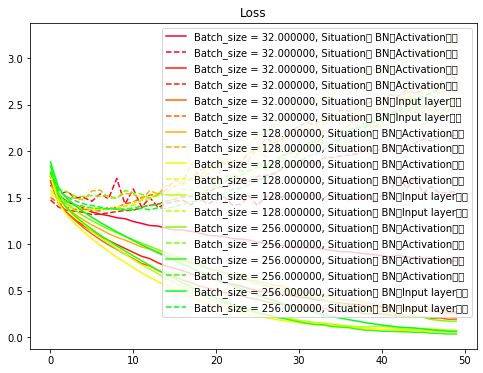

C:\Users\Harry\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 28858 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Harry\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 22312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Harry\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 20043 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Harry\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24460 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Harry\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 21069 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Harry\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 28858 missing from c

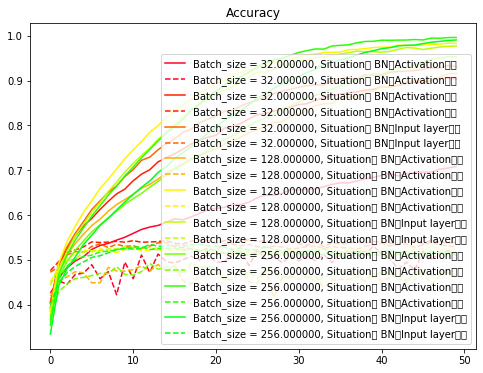

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
